In [1]:
import requests
import pandas as pd

url = "https://cea.nic.in/api/psp_energy.php"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()  # Parse JSON response
else:
    raise Exception(f"Failed to fetch data: {response.status_code}")

# Step 2: Extract data for Delhi
# Combine data from all financial years (keys of the JSON)
delhi_data = []
for year, records in data.items():
    for record in records:
        if record["State"].strip().lower() == "delhi":
            delhi_data.append(record)

# Step 3: Convert to DataFrame
delhi_df = pd.DataFrame(delhi_data)

# Step 4: Clean and process the DataFrame
# Convert numeric columns from strings to floats
delhi_df["energy_requirement"] = pd.to_numeric(delhi_df["energy_requirement"], errors='coerce')
delhi_df["energy_availability"] = pd.to_numeric(delhi_df["energy_availability"], errors='coerce')

# Optional: Remove unwanted columns (e.g., "ID" or others)
delhi_df = delhi_df.drop(columns=["ID"], errors="ignore")


# Save to a CSV file
delhi_df.to_csv("delhi_energy_data.csv", index=False)


In [2]:
delhi_df=pd.read_csv("delhi_energy_data.csv")
print(delhi_df.tail())

       Month   State  energy_requirement  energy_availability         fy
60  Feb-2024   Delhi         2187.056741          2186.382543  2023-2024
61  Mar-2024   Delhi         2216.859549          2216.642283  2023-2024
62  Apr-2024   Delhi         2859.951076          2859.635923  2024-2025
63  May-2024   Delhi         4207.625879          4204.963102  2024-2025
64  Jun-2024   Delhi         4545.508396          4540.582260  2024-2025


In [3]:
delhi_df=delhi_df.set_index('fy')
delhi_df.head()

,Month,State,energy_requirement,energy_availability
fy,,,,
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Jan-2020,Delhi,2290.02,2290.02
2019-2020,Feb-2020,Delhi,1904.80,1904.53
2019-2020,Feb-2020,Delhi,1904.80,1904.53


In [4]:
print(delhi_df.describe())

       energy_requirement  energy_availability
count           65.000000            65.000000
mean          2531.382118          2530.622904
std            937.941350           937.248663
min            183.000000           183.000000
25%           2090.545000          2090.149000
50%           2290.020000          2290.020000
75%           3201.586000          3200.931000
max           4545.508396          4540.582260


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

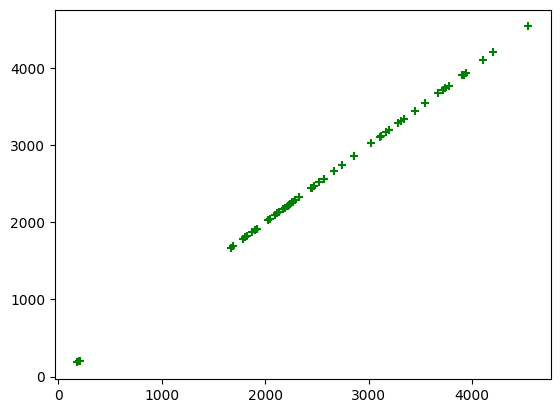

In [6]:

plt.scatter(delhi_df['energy_requirement'],delhi_df['energy_availability'],marker="+",color='green')

plt.show()

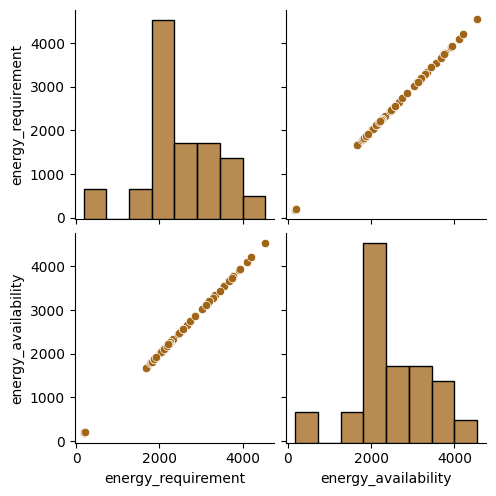

In [7]:

sns.set_palette('BrBG')
sns.pairplot(delhi_df)

Epoch 1/50


e:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.2830 - mae: 0.4832 - val_loss: 0.4724 - val_mae: 0.6572
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2804 - mae: 0.4908 - val_loss: 0.4234 - val_mae: 0.6182
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2522 - mae: 0.4660 - val_loss: 0.3749 - val_mae: 0.5765
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2057 - mae: 0.4138 - val_loss: 0.3196 - val_mae: 0.5242
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1660 - mae: 0.3705 - val_loss: 0.2517 - val_mae: 0.4506
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1346 - mae: 0.3249 - val_loss: 0.1710 - val_mae: 0.3561
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0924 - mae: 0.2562 - val_loss: 0.0952 - val_mae: 0.2626
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0686 - mae: 0.2084 - val_loss: 0.0686 - val_mae: 0.2184
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0699 - mae: 0.2044 - val_loss: 

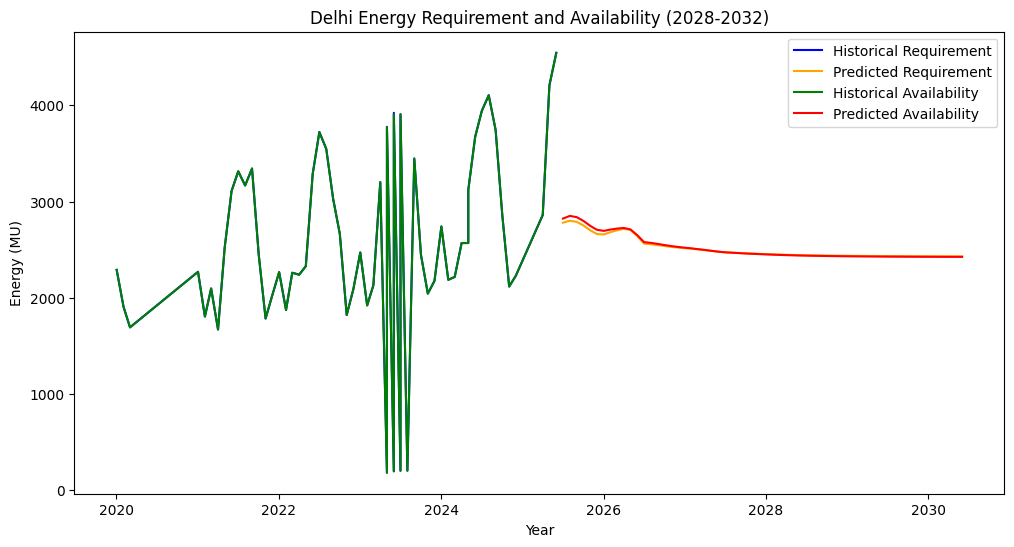

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Create a datetime index from fiscal year and month
delhi_df['datetime'] = pd.to_datetime(delhi_df['Month'] + '-01-' + delhi_df.index.str.split('-').str[1])
delhi_df = delhi_df.sort_values('datetime')
delhi_df.set_index('datetime', inplace=True)

# Select the features to predict
data = delhi_df[['energy_requirement', 'energy_availability']].values

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 12  # Use 12 months for prediction
x, y = create_sequences(data_scaled, sequence_length)

# Split into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, 2), return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(2)  # Predict both requirement and availability
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Generate predictions for future years (2028-2032)
future_steps = 5 * 12  # 5 years of monthly predictions
input_sequence = data_scaled[-sequence_length:]

predictions = []
for _ in range(future_steps):
    pred = model.predict(input_sequence[np.newaxis, :, :])[0]
    predictions.append(pred)
    input_sequence = np.vstack([input_sequence[1:], pred])

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

# Create a datetime index for the future predictions
last_date = delhi_df.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(predictions, columns=['energy_requirement', 'energy_availability'], index=future_dates)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(delhi_df.index, delhi_df['energy_requirement'], label="Historical Requirement", color='blue')
plt.plot(future_df.index, future_df['energy_requirement'], label="Predicted Requirement", color='orange')
plt.plot(delhi_df.index, delhi_df['energy_availability'], label="Historical Availability", color='green')
plt.plot(future_df.index, future_df['energy_availability'], label="Predicted Availability", color='red')
plt.title("Delhi Energy Requirement and Availability (2028-2032)")
plt.xlabel("Year")
plt.ylabel("Energy (MU)")
plt.legend()
plt.show()
